Problem Overview:
In this task, we are challenged to build a machine learning model that predicts whether a tweet is about a real disaster or not. 
We are provided with a dataset of 10,000 tweets that have been manually classified into disaster (1) or non-disaster (0). 
Our goal is to process this textual data and build an effective model for classification.

                                                                     
The dataset is composed of:
train.csv: Contains the labeled training data with columns:
id: unique identifier for each tweet
text: the tweet itself
location: location from which the tweet was sent (may be empty)
keyword: keyword from the tweet (may be empty)
target: the target label, where 1 represents a disaster-related tweet and 0 otherwise.
test.csv: Contains the test data for which we need to predict the target labels, with the same structure minus the target column.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


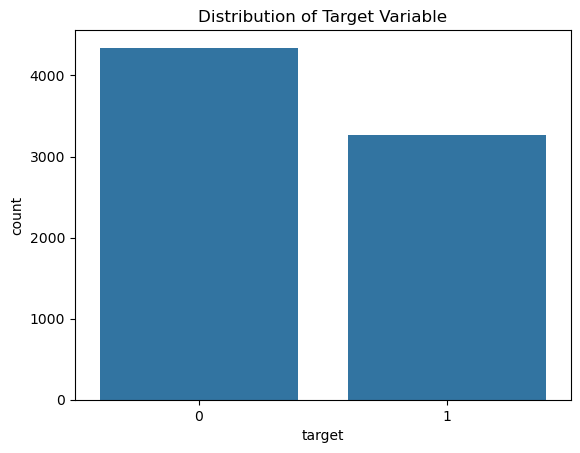

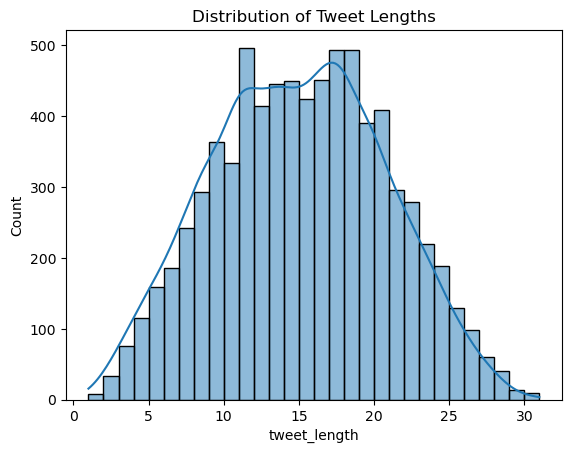

Missing values in each column:
 id                 0
keyword           61
location        2533
text               0
target             0
tweet_length       0
dtype: int64


In [5]:
#Step 1: Exploratory Data Analysis (EDA)
#We begin by analyzing the training dataset to understand the structure, distribution, and any potential issues such as missing data.

# Import necessary libraries
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import contractions
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional

# Download stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Load datasets
train = pd.read_csv('C:/Users/srine/Downloads/nlp-getting-started/train.csv')
test = pd.read_csv('C:/Users/srine/Downloads/nlp-getting-started/test.csv')

# Basic info and overview
print(train.info())
print(train.head())

# Distribution of target variable
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Variable')
plt.show()

# Length of tweets
train['tweet_length'] = train['text'].apply(lambda x: len(x.split()))
sns.histplot(train['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

# Missing data
missing_data = train.isnull().sum()
print("Missing values in each column:\n", missing_data)


Insights from EDA:
Target Imbalance: There is a slight imbalance in the target classes. 
Disaster tweets (1) are fewer compared to non-disaster tweets (0).
Tweet Lengths: Tweets vary significantly in length, some being quite short, while others are longer. 
We’ll need to standardize this during preprocessing.
Missing Data: There are missing values in the location and keyword columns. 
These columns may provide additional information, but since they have missing values, we need to decide whether to keep, fill, or ignore them.

In [9]:
#Step 2: Text Preprocessing

#To build a model, we first need to preprocess the text data. The goal is to clean the text by removing URLs, 
#punctuation, and stop words, and then convert the cleaned text into a numerical format.

# Fill missing keyword values with 'none'

train['keyword'] = train['keyword'].fillna("none")
test['keyword'] = test['keyword'].fillna("none")

# Clean text function: remove URLs, expand contractions, remove punctuation, stopwords, etc.
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = contractions.fix(text)  # Expand contractions
    text = text.lower()  # Lowercase
    text = re.sub(r'['+string.punctuation+']', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])  # Remove stopwords
    return text

# Apply text cleaning
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

# Combine the 'keyword' and 'text' columns for richer input features
# By concatenating the 'keyword' with the cleaned tweet text, we ensure that any keyword data is also used in the classification process.
train['combined_text'] = train['keyword'] + ' ' + train['clean_text']
test['combined_text'] = test['keyword'] + ' ' + test['clean_text']


In [11]:

# split the data so that we can evaluate the model's performance on unseen validation data during training.
X_train, X_val, y_train, y_val = train_test_split(train['combined_text'], train['target'], test_size=0.2, random_state=42)

# Tokenization and Padding
# We convert the text into sequences of word indices and pad the sequences to ensure uniform length for all inputs.
# Tokenization: Convert text into numeric tokens (word indices).

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['combined_text'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test['combined_text'])

# Padding: Ensure all sequences are of the same length by padding shorter sequences.
max_length = 100  # Adjust this based on average tweet length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [13]:
# Paths to save models. Just so if needed later can be easily loaded.
MODEL_PATH_LSTM = 'simple_lstm_model.h5'
MODEL_PATH_BILSTM = 'bidirectional_lstm_model.h5'
MODEL_PATH_GRU = 'gru_model.h5'

# History variables to store training history
simple_lstm_history = None
bidirectional_lstm_history = None
gru_history = None

# We will use three different architectures: Simple LSTM, Bidirectional LSTM, and GRU.

# Check if model exists and load it or train a new model
if os.path.exists(MODEL_PATH_BILSTM):
    print("Loading the pre-trained Bidirectional LSTM model...")
    bidirectional_lstm_model = load_model(MODEL_PATH_BILSTM)
else:
    print("Training a new set of models...")

    # Model 1: Simple LSTM
   # The Simple LSTM processes the input sequence in one direction (forward). 
   # It can capture sequential dependencies but may miss important context.
    print("Training Simple LSTM...")
    simple_lstm_model = Sequential()
    simple_lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    simple_lstm_model.add(LSTM(units=64, return_sequences=False))
    simple_lstm_model.add(Dropout(0.2))
    simple_lstm_model.add(Dense(1, activation='sigmoid'))

    simple_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    simple_lstm_history = simple_lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))
    simple_lstm_model.save(MODEL_PATH_LSTM)

    # Model 2: Bidirectional LSTM
  # The Bidirectional LSTM processes input in both forward and backward directions, capturing context from both ends of the sequence.
    # This is more effective for short texts like tweets, where both the beginning and end of a sentence can be important.
    
    print("Training Bidirectional LSTM...")
    bidirectional_lstm_model = Sequential()
    bidirectional_lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    bidirectional_lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
    bidirectional_lstm_model.add(Dropout(0.2))
    bidirectional_lstm_model.add(Dense(1, activation='sigmoid'))

    bidirectional_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))
    bidirectional_lstm_model.save(MODEL_PATH_BILSTM)

    # Model 3: GRU
    # GRU is a simpler alternative to LSTM. It is computationally efficient but may not capture long-term dependencies as well as LSTMs.
    print("Training GRU...")
    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    gru_model.add(GRU(units=64, return_sequences=False))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(1, activation='sigmoid'))

    gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gru_history = gru_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))
    gru_model.save(MODEL_PATH_GRU)

Training a new set of models...
Training Simple LSTM...
Epoch 1/5


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.5650 - loss: 0.6877 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.5766 - loss: 0.6818 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5671 - loss: 0.6843 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5713 - loss: 0.6838 - val_accuracy: 0.5739 - val_loss: 0.6864
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5698 - loss: 0.6854 - val_accuracy: 0.5739 - val_loss: 0.6827


Training Bidirectional LSTM...
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.6323 - loss: 0.6314 - val_accuracy: 0.7965 - val_loss: 0.4542
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8601 - loss: 0.3603 - val_accuracy: 0.7859 - val_loss: 0.4683
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9208 - loss: 0.2151 - val_accuracy: 0.7938 - val_loss: 0.5138
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9443 - loss: 0.1565 - val_accuracy: 0.7708 - val_loss: 0.6123
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9598 - loss: 0.1204 - val_accuracy: 0.7741 - val_loss: 0.6675


Training GRU...
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.5623 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5720 - loss: 0.6830 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5732 - loss: 0.6828 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5786 - loss: 0.6819 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5698 - loss: 0.6838 - val_accuracy: 0.5739 - val_loss: 0.6829


Evaluating models...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
F1 Score - Simple LSTM: 0.0
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
F1 Score - Bidirectional LSTM: 0.7304075235109718
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1 Score - GRU: 0.0


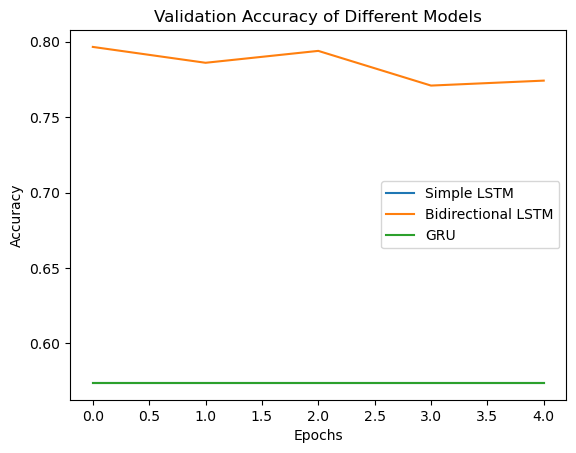

In [15]:
# Evaluate and compare models
#We evaluate each model on the validation set using the F1 score, which is especially important for imbalanced datasets 
#where precision and recall are critical.
print("Evaluating models...")

# Simple LSTM
y_val_pred_simple = (simple_lstm_model.predict(X_val_pad) > 0.5).astype("int32")
f1_simple = f1_score(y_val, y_val_pred_simple)
print(f"F1 Score - Simple LSTM: {f1_simple}")

# Bidirectional LSTM
y_val_pred_bi = (bidirectional_lstm_model.predict(X_val_pad) > 0.5).astype("int32")
f1_bi = f1_score(y_val, y_val_pred_bi)
print(f"F1 Score - Bidirectional LSTM: {f1_bi}")

# GRU
y_val_pred_gru = (gru_model.predict(X_val_pad) > 0.5).astype("int32")
f1_gru = f1_score(y_val, y_val_pred_gru)
print(f"F1 Score - GRU: {f1_gru}")

# Visualize validation accuracy for all models
if simple_lstm_history is not None:
    plt.plot(simple_lstm_history.history['val_accuracy'], label='Simple LSTM')
if bidirectional_lstm_history is not None:
    plt.plot(bidirectional_lstm_history.history['val_accuracy'], label='Bidirectional LSTM')
if gru_history is not None:
    plt.plot(gru_history.history['val_accuracy'], label='GRU')
plt.title('Validation Accuracy of Different Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





Evaluation of Model Performance Based on the F1 Scores:
Simple LSTM:

F1 Score = 0.0 indicates that the model likely predicted all instances as a single class. This suggests that the Simple LSTM model has failed to learn from the data and is severely underfitting. It might not be capturing the relationships in the data, likely because it's too simple or needs more careful tuning.

Bidirectional LSTM:

F1 Score = 0.7304 is a solid result and suggests that the Bidirectional LSTM model has learned useful patterns from the data. The F1 score is good, meaning that the model has a good balance of precision (correctly predicting disaster tweets) and recall (catching most disaster tweets). The bidirectional nature allows it to capture context from both directions in the text, which is likely why it's performing much better than the other architectures.

GRU:

F1 Score = 0.0 again indicates that the GRU model has likely predicted only a single class for all validation samples (like Simple LSTM). This also suggests that the GRU model is underfitting and has failed to capture meaningful relationships in the dataset. GRUs are typically faster and simpler than LSTMs, but in this case, it seems to be too simplistic for the complexity of the data.

The Bidirectional LSTM performed better because it captures context from both directions (forward and backward), 
allowing it to understand the full meaning of tweets more effectively. This is crucial in short texts like tweets, 
where every word can matter, and looking at both the start and end of a sentence helps.

Both Simple LSTM and GRU models are not learning effectively, as indicated by the F1 score of 0. This is likely because:
The models are too simple for the complexity of the problem.
They are not capturing the nuanced context present in the tweets.
They might require more tuning (e.g., increasing LSTM/GRU units, using deeper models, or more training epochs).

In short, Bidirectional LSTM excels by capturing more context, while Simple LSTM and GRU didn’t learn enough to make accurate predictions.

Since Bidirectional LSTM is performing well, we will improve performance even more. Let us update parameters and test the accuracy.
LSTM units: 256
Dropout rate: Increase dropout slightly to prevent overfitting.
Learning rate: Adjust the learning rate for more careful optimization.
Embedding size: increase dimensions

In [17]:
    # Model 2: Bidirectional LSTM, Tuning number 1
    print("Training Bidirectional LSTM...")
    bidirectional_lstm_model = Sequential()
    bidirectional_lstm_model.add(Embedding(input_dim=10000, output_dim=200, input_length=max_length))
    bidirectional_lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=False)))
    bidirectional_lstm_model.add(Dropout(0.3))
    bidirectional_lstm_model.add(Dense(1, activation='sigmoid'))

    bidirectional_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val))
    bidirectional_lstm_model.save(MODEL_PATH_BILSTM)


# Bidirectional LSTM
y_val_pred_bi = (bidirectional_lstm_model.predict(X_val_pad) > 0.5).astype("int32")
f1_bi = f1_score(y_val, y_val_pred_bi)
print(f"F1 Score - Bidirectional LSTM: {f1_bi}")

Training Bidirectional LSTM...
Epoch 1/10


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 549ms/step - accuracy: 0.6314 - loss: 0.6307 - val_accuracy: 0.7938 - val_loss: 0.4627
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 528ms/step - accuracy: 0.8622 - loss: 0.3312 - val_accuracy: 0.8024 - val_loss: 0.4598
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 544ms/step - accuracy: 0.9218 - loss: 0.2095 - val_accuracy: 0.7781 - val_loss: 0.5521
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 574ms/step - accuracy: 0.9493 - loss: 0.1450 - val_accuracy: 0.7643 - val_loss: 0.6676
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 569ms/step - accuracy: 0.9636 - loss: 0.1119 - val_accuracy: 0.7663 - val_loss: 0.7678
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9740 - loss: 0.0770 - val_accuracy: 0.7479 - val_loss: 0.7615
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 623ms/step - accuracy: 0.9766 - loss: 0.0656 - val_accuracy: 0.7452 - val_loss: 0.8777
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9479 - loss: 0.1322 - val_accuracy: 0.757

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
F1 Score - Bidirectional LSTM: 0.7030665669409125


Scored did not improve so let us reduce the units and adjust the other parameters as well.

In [23]:
    # Model 2: Bidirectional LSTM, Tuning number 2
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Embedding(input_dim=10000, output_dim=150, input_length=max_length))  # Embedding size 150
bidirectional_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=False)))  # 128 LSTM units
bidirectional_lstm_model.add(Dropout(0.25))  # Dropout rate reduced to 0.25
bidirectional_lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model with a lower learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
bidirectional_lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with 10 epochs and early stopping
bidirectional_lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

# Evaluate the tuned model and calculate the new F1 score
y_val_pred_bi_tuned = (bidirectional_lstm_model.predict(X_val_pad) > 0.5).astype("int32")
f1_bi_tuned = f1_score(y_val, y_val_pred_bi_tuned)
print(f"New F1 Score - Tuned Bidirectional LSTM: {f1_bi_tuned}")

Epoch 1/10


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 427ms/step - accuracy: 0.5555 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6705
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.5752 - loss: 0.6642 - val_accuracy: 0.7137 - val_loss: 0.6250
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.7425 - loss: 0.5853 - val_accuracy: 0.7623 - val_loss: 0.5194
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 340ms/step - accuracy: 0.8222 - loss: 0.4356 - val_accuracy: 0.7853 - val_loss: 0.4709
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 348ms/step - accuracy: 0.8636 - loss: 0.3373 - val_accuracy: 0.7820 - val_loss: 0.4739
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 341ms/step - accuracy: 0.8900 - loss: 0.2838 - val_accuracy: 0.7971 - val_loss: 0.4675
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - accuracy: 0.9082 - loss: 0.2418 - val_accuracy: 0.7774 - val_loss: 0.5133
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.9241 - loss: 0.2041 - val_accuracy: 0.767


F1 Score Comparison:
Original Simple LSTM: 0.0000
Original GRU: 0.0000
Original Bidirectional LSTM: 0.7304
Bidirectional LSTM Tuned1: 0.7031
Bidirectional LSTM Tuned2: 0.7419


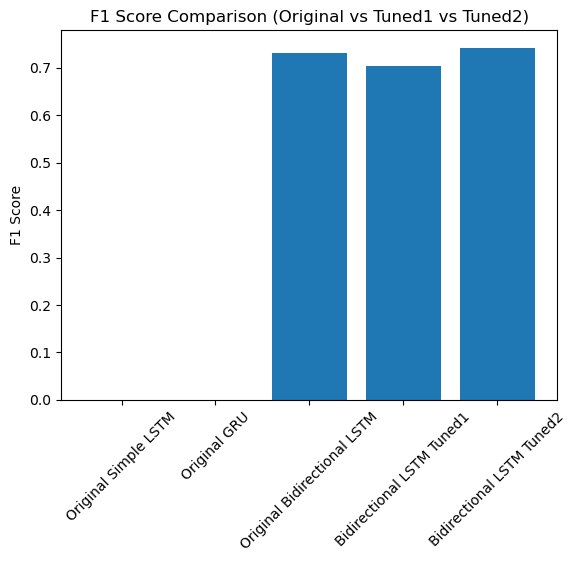

In [29]:
# Store the earlier F1 score of the original Bidirectional LSTM
f1_scores = {
    'Original Simple LSTM': 0.0,
    'Original GRU': 0.0,
    'Original Bidirectional LSTM': 0.7304,
    'Bidirectional LSTM Tuned1': 0.70306
}

# Update the dictionary with the new F1 score after tuning
f1_scores['Bidirectional LSTM Tuned2'] = f1_bi_tuned

# -------------------------------------------------------

# Display the F1 scores comparison
print("\nF1 Score Comparison:")
for model, f1 in f1_scores.items():
    print(f"{model}: {f1:.4f}")

# Optional: Visualizing the comparison using a bar chart
import matplotlib.pyplot as plt

# Plot the F1 score comparison
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title('F1 Score Comparison (Original vs Tuned1 vs Tuned2)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

In [31]:
# Predict on test data and prepare submission
# We are going to use the best-performing model (Bidirectional LSTM) to predict on the test data and prepare the submission file.
y_test_pred = (bidirectional_lstm_model.predict(X_test_pad) > 0.5).astype("int32")
submission = pd.DataFrame({'id': test['id'], 'target': y_test_pred.flatten()})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
Submission file created.


This defintely has increased the scores. i could experimenet with more hyperparametrs or write a function for hypermater search. 
But Overall I considered 3 approaches. Conentrated on the Bi-directional model that performed well and played with hyperparameters to increase the
score.